# Test tiger with bernoulli regression

In [25]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger 
import tigerpy.bbvi as bbvi

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd

rng = np.random.default_rng(42)

## Simulate data

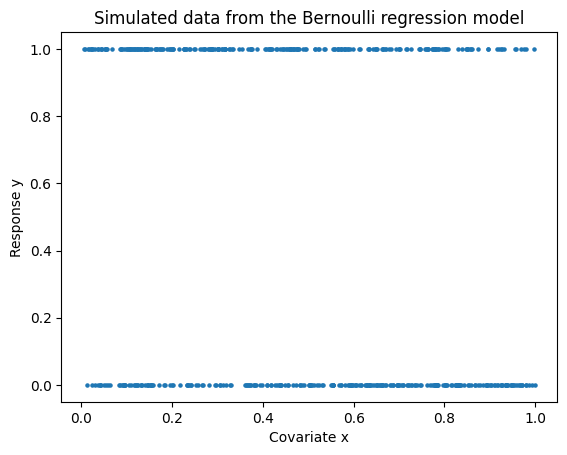

In [26]:
# sample size and true parameters

n = 500
true_beta = np.array([1.0, -2.0])

# data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
nu = X_mat @ true_beta 
mu = np.exp(nu)/(1 + np.exp(nu))
response_vec = rng.binomial(n=1, p=mu, size=n)

# plot the simulated data

plt.scatter(x0, response_vec, s = 5)
plt.title("Simulated data from the Bernoulli regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up the model in tigerpy

In [27]:
# set up design matrix 
X = tiger.Obs(name = "X")
X.fixed(data = x0)

# set up hyperparameters
beta_loc = tiger.Hyper(0, name="beta_loc")
beta_scale = tiger.Hyper(100, name="beta_scale")

# set up parameters
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up the linear predictor
lpred = tiger.Lpred(Obs=X, beta=beta)

# set up response distribution
response_dist = tiger.Dist(tfd.Bernoulli, logits=lpred)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [11]:
graph = tiger.ModelGraph(Model=m)
graph.build_graph()

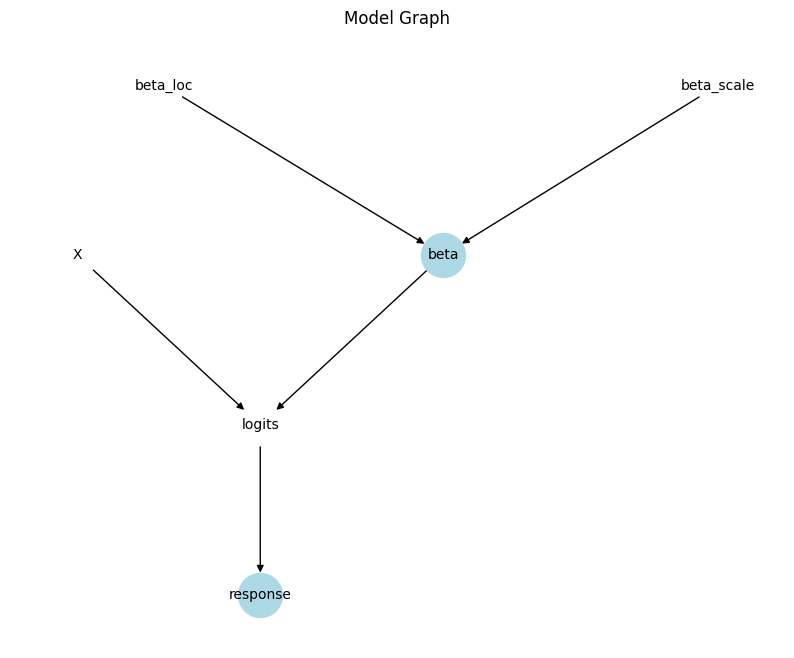

In [12]:
graph.visualize_graph()

## Inference with BBVI

In [13]:
q = bbvi.Bbvi(Graph=graph, num_samples=64, num_iterations=10000, key=27)

In [14]:
q.run_bbvi(step_size=0.001, threshold=1e-5, chunk_size=25)

(Array(-345.52463, dtype=float32),
 {'beta': {'mu': Array([ 0.7319999, -1.5485356], dtype=float32),
   'cov': Array([[ 0.04043702, -0.06802922],
          [-0.06802922,  0.14841527]], dtype=float32)}})

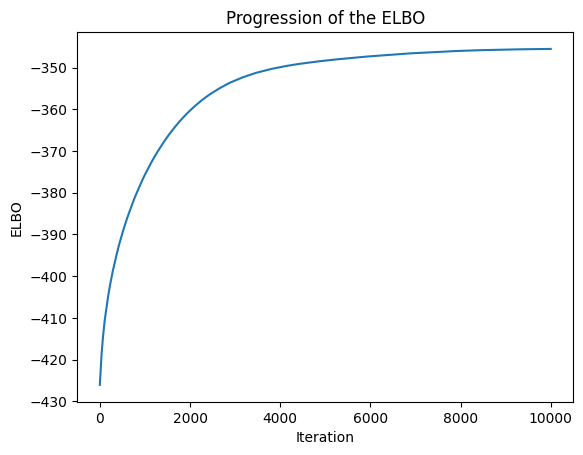

In [15]:
q.plot_elbo()